<a href="https://colab.research.google.com/github/brngl/topic-modeling-on-bob-dylan-lyrics/blob/master/Bob_Dylan_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Topic Modeling on Bob Dylan lyrics

Lyrics texts are provided by this project:
https://github.com/mulhod/bob_dylan_lyrics

It's performed LDA on Bob Dylan lyrics using a variable number of topics.

For each LDA run with a different number of topics, it's shown a word cloud created taking in count the words that appears in topics and their scores. The word cloud is created from a text file containing the words from topics. Every word has an occurence in the text dicrectly proportional to his score in his topic of origin.

## Input creation

The first step is the creation of the input. It is a text file in which every row corresponds to a lyric in plain. For each replicated lyric (for example the ones that belong to different albums or different versions of the same song), it's took just a copy. Lyrics source is a set of .txt files in which every file is a lyric.

## Preprocessing

The input is cleaned up from english stopwords. Beyond the usual english stopwords, are eliminated names of persons, name of places and words belonging to english slang.

After that, it's used a TF-IDF function to delete less relevant words.

- Stemming: the excecution is performed both with word stemming and without, so, for the first case, it's applied a stemming by Porter to the document.

The corpus thus obtained could be saved in a text file.

## Execution

LDA is performed both with Porter stemming and without. For both cases are made different runs with a different number of topic. 

At the end of each run are shown topics and their respective word clouds.

---
###### I used [gensim](https://radimrehurek.com/gensim/) API.
---





##### Mount GDrive

In [0]:
import sys
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Bob Dylan Topic Modeling'
sys.path.append('/content/gdrive/My Drive/Bob Dylan Topic Modeling')

path_testi = '/content/gdrive/My Drive/Bob Dylan Topic Modeling/songs'
path_files = '/content/gdrive/My Drive/Bob Dylan Topic Modeling/texts'
path_images = '/content/gdrive/My Drive/Bob Dylan Topic Modeling/images'

### Word Cloud Creation

In [0]:
"""
Masked wordcloud
================
Using a mask you can generate wordclouds in arbitrary shapes.
"""

from wordcloud import WordCloud
from matplotlib.pyplot import figure

def show_word_cloud (text, mask_image = ''):
    wc = None
    if mask_image == '':
        wc = WordCloud(background_color="black", max_words=2000, collocations=False) #, mask=mask)
    else:
        wc = WordCloud(background_color="black", max_words=2000, collocations=False, mask=mask)
    wc.generate(text)
    figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

### Definition of LDA supporting class

In [0]:
import os
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import operator


class LDA:
    def __init__(self, lyrics_path, doStem, createCorpus = False):
        self.path = lyrics_path
        self.doStem = doStem
        self.createCorpus = createCorpus
        self.lyrics = os.listdir(lyrics_path)
        self.p_stemmer = PorterStemmer()
        self.tokenizer = RegexpTokenizer(r'\w+')
        nltk.download('stopwords')
        self.en_stop = stopwords.words('english')
        self.tokenize_stop_words()
        

    def create_matrix(self):
        lyrics = list()
        for title in self.lyrics:
             #ignoro le canzoni duplicate
             if title[len(title)-5 : -4] == '1':
                 title_t = title[:len(title)-6]
                 lyric = open(self.path+'/'+title).read()
                 lyric = self.stopped_tokens(tokenizer.tokenize(lyric.lower()))
                 title_t = str(title_t).replace("_"," ")
                 title_t = self.stopped_tokens(tokenizer.tokenize(title_t.lower()))
                 if self.doStem:
                     title_t = self.stem(title_t)
                     lyric = self.stem(lyric)
                 title_t.extend(lyric)
                 lyrics.append(title_t)


    def create_and_save_corpus(self, num_docs):
        ris = list()
        dist = dict()
        tokenizer = RegexpTokenizer(r'\w+')
        num_docs = num_docs
        
        lyrics = self.create_matrix()

        for lyric in lyrics:
            lyrics_p = list()
            for tok in lyric:
                t_freq = lyric.count(tok)
                #count_other: num di volte che il termine occorre in altri documenti
                count_other = self.word_occurrence(tok, lyrics, lyric) 
                count_total = self.word_occurrence_total(tok , lyrics)
                idf = 0
                if count_other != 0:
                    idf = math.log10(num_docs/count_other)
                dist[tok] = freq
                if (freq < 0.35 and t_freq > 1):
                    try:
                        lyrics_p.append(unicode(lyric[tok], errors='ignore'))
                    except TypeError:
                        lyrics_p.append(lyric[tok])
            #Ignoro i testi vuoti
            if len(lyrics_p) > 0:
                ris.append(lyrics_p)
        dist = sorted(dist.items(), key=operator.itemgetter(1))
        self.write_corpus_on_file(ris)
        return ris


    def write_corpus_on_file(self, corpus, path="texts/corpus"):
        if self.doStem:
            path+="_stem"
        print ("Saving path", path)
        with open(path, 'w') as outfile:
                 for lyric in corpus:
                     for word in lyric:
                        outfile.write(word+' ')
                     outfile.write('\n')


    def get_corpus(self, path):
        path = path+"/corpus"
        if self.doStem:
            path+="_stem"
        corpus = open(path)
        corpus = [lyric.split() for lyric in corpus.readlines()]
        return corpus


    def word_occurrence(self, word, total, lyric):
        count = 0
        for testo in total:
            if testo != lyric and word in testo:
                count+=1
        return count


    def word_occurrence_total(self, word, total):
        count = 0
        for testo in total:
            count+=testo.count(word)
        return count


    # Clean code from unexpected ascii code.
    def purify(s):
        exclude = ["\xe2"]
        for i in exclude:
            if s.endswith("\xe2"):
                return s[:-1]
        return s


    def tokenize_stop_words(self):
        tok = list()
        for stop_word in self.en_stop:
            tok = [t for t in self.tokenizer.tokenize(stop_word)]
        self.en_stop = tok


    def add_stop_words(self, path):
        doc = open(path).read()
        tokens = self.tokenizer.tokenize(doc)
        tok = [x for x in tokens]
        for t in tok:
            if t not in self.en_stop:
                self.en_stop.append(t)
        self.tokenize_stop_words()
        return self.en_stop


    def stopped_tokens(self, tokens):
        stopped_tokens = [i for i in tokens if not i in self.en_stop and len(i) > 2]
        return stopped_tokens


    # Stemming via Porter
    def stem(self, words):
        stemmed_words = list()
        for w in words:
            try:
                stemmed = self.p_stemmer.stem(w)
                stemmed_words.append(stemmed)
            except UnicodeDecodeError:
                pass
        return stemmed_words


    def write_ldamodel_for_wc(self, ldamodel):
        out = str()
        topics = ldamodel.show_topics(ldamodel.num_topics, num_words=50, formatted=False)
        for topic in topics:
            word_list = topic[1]  # una tupla (numTopic, topic)
            for word_freq in word_list:
                occ = int(word_freq[1]*100000)
                out += (word_freq[0]+' ')*occ
        return out

### Initialize model parameters

In [0]:
import sys
import math
import random
import numpy
import numpy as np
import matplotlib.pyplot as plt
from os import path
from gensim.corpora import dictionary
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

from gensim import corpora
import gensim

def one(x):
    return x

def log_norm(x):
    return 1 + np.log10(x)
'''
if create_corpus == True, corpus will be created starting from lyrics;
else, existing corpus will be loaded.
'''
create_corpus = False
n_topics_range = (5, 30)
passo = 5
path = path_files
iterations = 1

### Topic Modeling without Porter Stemming

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
TOPIC MODEL WITH NO PORTER STEMMING

LDA with 5 topics:
Topic n. 0
(0, '0.005*"feel" + 0.004*"love" + 0.004*"live" + 0.004*"town" + 0.004*"honey" + 0.004*"eyes" + 0.004*"thunder" + 0.003*"heart" + 0.003*"things" + 0.003*"heard" + 0.003*"dark" + 0.003*"door" + 0.003*"woman" + 0.003*"dollar" + 0.003*"listen" + 0.003*"gal" + 0.003*"mind" + 0.003*"lord" + 0.003*"hear" + 0.003*"goodbye"')

Topic n. 1
(1, '0.007*"mind" + 0.005*"wrong" + 0.004*"stand" + 0.004*"night" + 0.004*"love" + 0.004*"dead" + 0.004*"good" + 0.003*"hide" + 0.003*"left" + 0.003*"morning" + 0.003*"high" + 0.003*"money" + 0.003*"eyes" + 0.003*"wait" + 0.003*"cut" + 0.003*"heart" + 0.003*"leave" + 0.003*"poor" + 0.003*"stay" + 0.002*"honey"')

Topic n. 2
(2, '0.004*"woman" + 0.004*"remember" + 0.004*"girl" + 0.004*"love" + 0.003*"bound" + 0.003*"light" + 0.003*"death" + 0.003*"night" + 0.003*"life" + 0.003*"

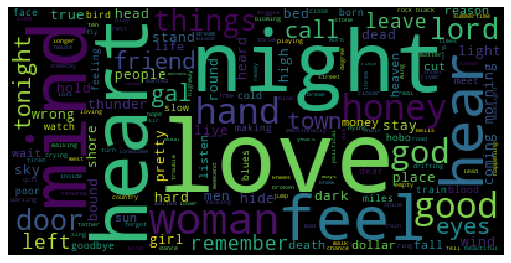

LDA with 10 topics:
Topic n. 0
(0, '0.007*"love" + 0.006*"heart" + 0.006*"tonight" + 0.005*"moon" + 0.005*"hear" + 0.005*"dear" + 0.004*"mind" + 0.004*"honey" + 0.004*"tomorrow" + 0.004*"walk" + 0.004*"moves" + 0.004*"wrong" + 0.004*"call" + 0.004*"fall" + 0.003*"fly" + 0.003*"weekend" + 0.003*"good" + 0.003*"heard" + 0.003*"teardrops" + 0.003*"happening"')

Topic n. 1
(1, '0.006*"close" + 0.005*"stand" + 0.004*"watch" + 0.004*"low" + 0.004*"leave" + 0.004*"wanted" + 0.004*"round" + 0.003*"country" + 0.003*"knees" + 0.003*"rolling" + 0.003*"hair" + 0.003*"lightly" + 0.003*"heaven" + 0.003*"dime" + 0.003*"pie" + 0.003*"night" + 0.003*"diamond" + 0.003*"empty" + 0.003*"shut" + 0.003*"standing"')

Topic n. 2
(2, '0.007*"hand" + 0.006*"woman" + 0.004*"lord" + 0.004*"night" + 0.004*"hold" + 0.004*"honey" + 0.004*"them" + 0.004*"girl" + 0.004*"ready" + 0.004*"mind" + 0.004*"love" + 0.003*"wallflower" + 0.003*"follow" + 0.003*"plow" + 0.003*"remain" + 0.003*"sun" + 0.003*"inside" + 0.003*"lov

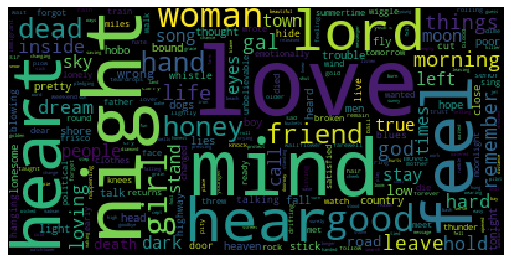

LDA with 15 topics:
Topic n. 0
(0, '0.007*"mind" + 0.007*"gal" + 0.006*"things" + 0.006*"them" + 0.005*"teardrops" + 0.005*"follow" + 0.005*"fall" + 0.005*"ring" + 0.005*"men" + 0.005*"bells" + 0.004*"spell" + 0.004*"wake" + 0.004*"hot" + 0.004*"rolling" + 0.004*"dead" + 0.004*"almighty" + 0.004*"advances" + 0.004*"garrett" + 0.004*"god" + 0.004*"song"')

Topic n. 1
(1, '0.006*"farewell" + 0.006*"cut" + 0.006*"stand" + 0.006*"woman" + 0.005*"summertime" + 0.005*"feeling" + 0.005*"dust" + 0.005*"head" + 0.005*"lonesome" + 0.005*"eyes" + 0.005*"bash" + 0.005*"leave" + 0.004*"girl" + 0.004*"cheek" + 0.004*"jet" + 0.004*"sunny" + 0.004*"pilot" + 0.004*"love" + 0.004*"handed" + 0.004*"hobo"')

Topic n. 2
(2, '0.008*"honey" + 0.007*"good" + 0.007*"love" + 0.006*"hand" + 0.005*"weekend" + 0.005*"mind" + 0.005*"feel" + 0.005*"sing" + 0.005*"live" + 0.005*"lord" + 0.005*"changed" + 0.004*"ten" + 0.004*"miles" + 0.004*"mornings" + 0.004*"blind" + 0.004*"rock" + 0.004*"turn" + 0.004*"drank" + 0.0

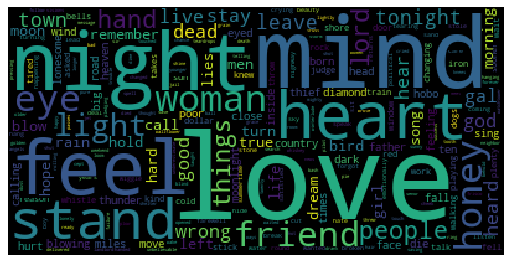

LDA with 20 topics:
Topic n. 0
(0, '0.008*"returns" + 0.007*"crowd" + 0.007*"pledging" + 0.007*"moon" + 0.006*"pity" + 0.006*"immigrant" + 0.006*"hoping" + 0.005*"saved" + 0.005*"iron" + 0.005*"bout" + 0.005*"glad" + 0.005*"latest" + 0.004*"complete" + 0.004*"unknown" + 0.004*"lamb" + 0.004*"feel" + 0.004*"waters" + 0.004*"oblivion" + 0.004*"salary" + 0.004*"vivian"')

Topic n. 1
(1, '0.011*"heaven" + 0.007*"leave" + 0.007*"trouble" + 0.007*"pure" + 0.007*"unbelievable" + 0.007*"road" + 0.006*"written" + 0.006*"eyes" + 0.005*"dark" + 0.005*"watered" + 0.005*"goddess" + 0.005*"tough" + 0.005*"ear" + 0.004*"answer" + 0.004*"tangled" + 0.004*"stand" + 0.004*"wagon" + 0.004*"jabbed" + 0.004*"stay" + 0.004*"trains"')

Topic n. 2
(2, '0.014*"remember" + 0.008*"woman" + 0.007*"love" + 0.006*"death" + 0.006*"grain" + 0.006*"stood" + 0.005*"moonlight" + 0.005*"asked" + 0.005*"killer" + 0.005*"people" + 0.005*"hung" + 0.005*"turn" + 0.005*"sand" + 0.005*"cry" + 0.005*"light" + 0.005*"face" + 0.0

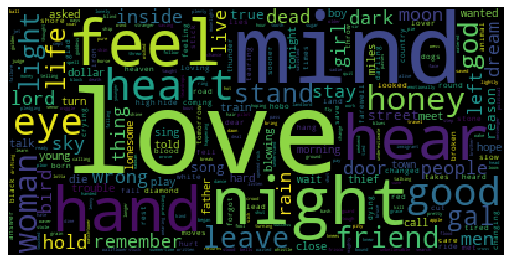

LDA with 25 topics:
Topic n. 0
(0, '0.009*"hold" + 0.009*"light" + 0.008*"father" + 0.008*"happening" + 0.007*"lies" + 0.007*"water" + 0.007*"judge" + 0.007*"high" + 0.007*"grain" + 0.006*"lead" + 0.006*"spell" + 0.006*"grace" + 0.006*"saving" + 0.006*"grow" + 0.006*"room" + 0.006*"forever" + 0.006*"sand" + 0.006*"hot" + 0.005*"advances" + 0.005*"garrett"')

Topic n. 1
(15, '0.007*"telling" + 0.007*"free" + 0.007*"love" + 0.007*"hobo" + 0.006*"winterlude" + 0.006*"angels" + 0.006*"work" + 0.006*"dogs" + 0.006*"tonight" + 0.005*"play" + 0.005*"farm" + 0.005*"lonesome" + 0.005*"solid" + 0.005*"symphony" + 0.005*"heart" + 0.005*"kind" + 0.005*"truck" + 0.005*"stops" + 0.005*"foundation" + 0.004*"dude"')

Topic n. 2
(14, '0.014*"god" + 0.010*"dollar" + 0.010*"pass" + 0.009*"gal" + 0.009*"wiggle" + 0.008*"call" + 0.008*"unbelievable" + 0.007*"bash" + 0.007*"shore" + 0.007*"stood" + 0.007*"streets" + 0.007*"judge" + 0.007*"ways" + 0.006*"ball" + 0.006*"people" + 0.006*"face" + 0.006*"coat" +

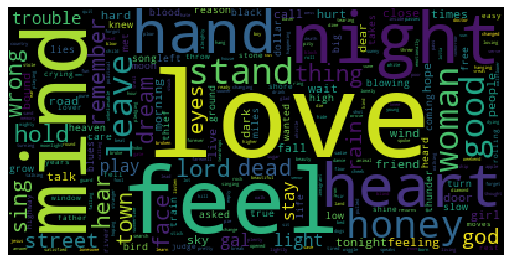

LDA with 30 topics:
Topic n. 0
(22, '0.007*"dreams" + 0.006*"saving" + 0.006*"grace" + 0.006*"bound" + 0.006*"killer" + 0.006*"times" + 0.006*"goodbye" + 0.006*"christmas" + 0.006*"leave" + 0.005*"stick" + 0.005*"sorrow" + 0.005*"constant" + 0.005*"colorado" + 0.005*"dream" + 0.005*"sooner" + 0.005*"vow" + 0.005*"cut" + 0.005*"latest" + 0.005*"adjust" + 0.005*"pony"')

Topic n. 1
(2, '0.012*"political" + 0.009*"delivered" + 0.009*"live" + 0.008*"shooting" + 0.007*"star" + 0.007*"property" + 0.007*"mobile" + 0.007*"resent" + 0.007*"plenty" + 0.007*"sooner" + 0.006*"slip" + 0.006*"stuck" + 0.006*"memphis" + 0.006*"bone" + 0.006*"stone" + 0.006*"jesus" + 0.006*"care" + 0.006*"rest" + 0.005*"thought" + 0.005*"tonight"')

Topic n. 2
(28, '0.011*"stand" + 0.010*"good" + 0.010*"father" + 0.009*"lonesome" + 0.008*"love" + 0.008*"feel" + 0.008*"save" + 0.008*"cheek" + 0.008*"sunny" + 0.008*"search" + 0.007*"send" + 0.007*"mornings" + 0.007*"blowing" + 0.007*"tied" + 0.006*"santa" + 0.006*"relea

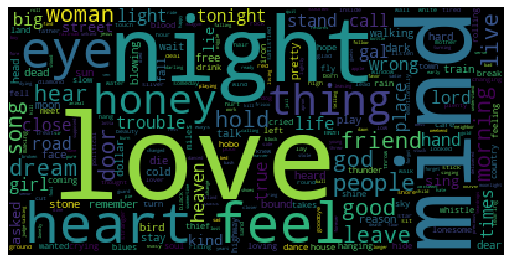

In [0]:
n_topics = n_topics_range[0]
lda = LDA(path, doStem=False, createCorpus=create_corpus)
lda.add_stop_words(path_files+'/stopwords8')

st = None
if create_corpus:
    st = lda.create_and_save_corpus(num_docs=399)
else:
    st = lda.get_corpus(path_files)

dic = corpora.Dictionary(st)
corpus = [dic.doc2bow(text) for text in st]
tfidf = TfidfModel(corpus, wlocal = log_norm)
corpus = tfidf[corpus]

print ("TOPIC MODEL WITH NO PORTER STEMMING\n")

while (n_topics <= n_topics_range[1]):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=n_topics, id2word=dic, passes=iterations)
    topics = ldamodel.print_topics(num_words=20)
    print ("LDA with "+str(n_topics)+" topics:")
    cont = 0
    for topic in topics:
        print("Topic n.", cont)
        print(topic)
        print()
        cont+=1
    print ()
    n_topics+=passo
    to_wc = lda.write_ldamodel_for_wc(ldamodel)
    show_word_cloud(to_wc)

### Topic Modeling with Porter Stemming

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
TOPIC MODEL WITH PORTER STEMMING

LDA with 5 topics:
Topic n. 0
(0, '0.005*"stay" + 0.005*"rememb" + 0.004*"road" + 0.004*"honey" + 0.004*"night" + 0.004*"true" + 0.004*"hope" + 0.004*"friend" + 0.004*"ring" + 0.004*"walk" + 0.003*"year" + 0.003*"blow" + 0.003*"hide" + 0.003*"kind" + 0.003*"judg" + 0.003*"woman" + 0.003*"dead" + 0.003*"hear" + 0.003*"fli" + 0.003*"bell"')

Topic n. 1
(1, '0.006*"feel" + 0.005*"night" + 0.005*"god" + 0.005*"dark" + 0.004*"stand" + 0.004*"good" + 0.004*"eye" + 0.004*"dream" + 0.004*"girl" + 0.004*"peopl" + 0.003*"fell" + 0.003*"thing" + 0.003*"heard" + 0.003*"heaven" + 0.003*"leav" + 0.003*"cri" + 0.003*"tonight" + 0.003*"care" + 0.003*"hand" + 0.003*"heart"')

Topic n. 2
(2, '0.005*"night" + 0.004*"live" + 0.004*"eye" + 0.004*"feel" + 0.003*"take" + 0.003*"place" + 0.003*"hand" + 0.003*"face" + 0.003*"wind" + 0.003*"move" + 0.003*"thing

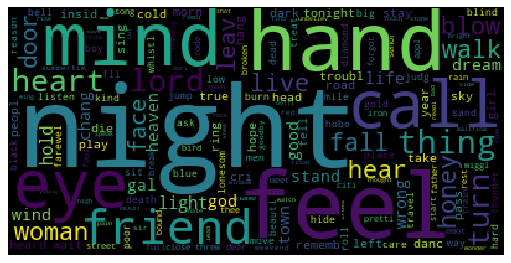

LDA with 10 topics:
Topic n. 0
(0, '0.007*"blow" + 0.007*"friend" + 0.006*"woman" + 0.005*"hear" + 0.005*"chang" + 0.004*"lord" + 0.004*"feel" + 0.004*"jump" + 0.004*"good" + 0.004*"left" + 0.004*"heart" + 0.004*"hard" + 0.004*"weekend" + 0.004*"quit" + 0.004*"eye" + 0.004*"die" + 0.004*"door" + 0.004*"night" + 0.003*"dream" + 0.003*"born"')

Topic n. 1
(1, '0.009*"honey" + 0.007*"live" + 0.007*"heart" + 0.006*"dollar" + 0.006*"moon" + 0.006*"night" + 0.005*"cri" + 0.005*"feel" + 0.005*"dream" + 0.005*"forgot" + 0.005*"wiggl" + 0.005*"mind" + 0.005*"father" + 0.004*"pledg" + 0.004*"unbeliev" + 0.004*"find" + 0.004*"watchtow" + 0.004*"bash" + 0.004*"insid" + 0.004*"silver"')

Topic n. 2
(2, '0.007*"hand" + 0.007*"turn" + 0.006*"mind" + 0.006*"fall" + 0.005*"rain" + 0.005*"friend" + 0.004*"night" + 0.004*"sky" + 0.004*"cri" + 0.004*"work" + 0.004*"move" + 0.004*"dear" + 0.004*"hear" + 0.004*"woman" + 0.004*"close" + 0.004*"life" + 0.004*"rest" + 0.004*"knew" + 0.004*"heart" + 0.004*"hang

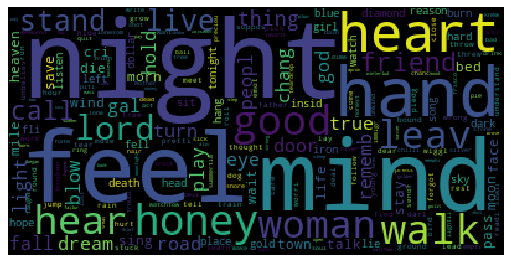

LDA with 15 topics:
Topic n. 0
(0, '0.007*"stone" + 0.007*"door" + 0.006*"feel" + 0.006*"dollar" + 0.006*"stand" + 0.006*"insid" + 0.005*"senor" + 0.005*"god" + 0.005*"hand" + 0.005*"look" + 0.005*"heaven" + 0.005*"sun" + 0.004*"call" + 0.004*"turn" + 0.004*"thing" + 0.004*"honey" + 0.004*"die" + 0.004*"bash" + 0.004*"shoe" + 0.004*"night"')

Topic n. 1
(1, '0.009*"stay" + 0.008*"troubl" + 0.007*"pass" + 0.007*"plenti" + 0.006*"mind" + 0.006*"stick" + 0.006*"morn" + 0.006*"night" + 0.006*"sir" + 0.005*"wake" + 0.005*"hate" + 0.005*"dime" + 0.005*"cri" + 0.005*"fli" + 0.005*"blow" + 0.005*"knee" + 0.005*"want" + 0.005*"start" + 0.004*"alley" + 0.004*"dri"')

Topic n. 2
(2, '0.009*"rain" + 0.008*"woman" + 0.007*"friend" + 0.007*"save" + 0.007*"hold" + 0.007*"gal" + 0.007*"hide" + 0.007*"girl" + 0.006*"wrong" + 0.006*"honey" + 0.006*"kind" + 0.005*"mind" + 0.005*"cept" + 0.005*"walk" + 0.005*"search" + 0.005*"ask" + 0.005*"hobo" + 0.004*"lover" + 0.004*"coin" + 0.004*"bucket"')

Topic n. 

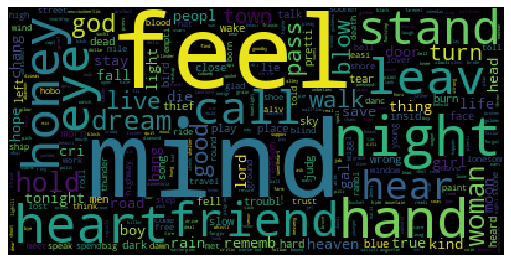

LDA with 20 topics:
Topic n. 0
(0, '0.008*"fell" + 0.007*"rapidli" + 0.007*"lonesom" + 0.007*"pilgrim" + 0.007*"tomb" + 0.007*"solid" + 0.007*"knock" + 0.007*"door" + 0.006*"heaven" + 0.006*"masterpiec" + 0.006*"foundat" + 0.006*"railroad" + 0.006*"critic" + 0.006*"tire" + 0.006*"spell" + 0.006*"garrett" + 0.006*"advanc" + 0.006*"play" + 0.006*"feel" + 0.006*"chang"')

Topic n. 1
(1, '0.009*"woman" + 0.007*"turn" + 0.007*"blow" + 0.006*"night" + 0.006*"hold" + 0.006*"moonlight" + 0.006*"began" + 0.005*"moon" + 0.005*"mind" + 0.005*"plow" + 0.005*"heart" + 0.005*"hand" + 0.005*"feel" + 0.005*"bucket" + 0.005*"shore" + 0.005*"mile" + 0.005*"town" + 0.005*"tell" + 0.005*"highway" + 0.004*"wear"')

Topic n. 2
(2, '0.010*"work" + 0.008*"summertim" + 0.008*"night" + 0.008*"stay" + 0.007*"shine" + 0.007*"search" + 0.007*"save" + 0.006*"peopl" + 0.006*"coat" + 0.006*"honest" + 0.006*"footstep" + 0.006*"tree" + 0.005*"farm" + 0.005*"auction" + 0.005*"dog" + 0.005*"tangl" + 0.005*"symphoni" + 0.

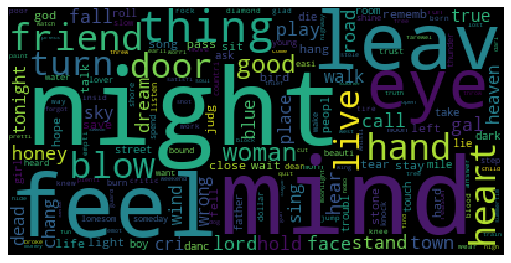

LDA with 25 topics:
Topic n. 0
(9, '0.010*"troubl" + 0.009*"street" + 0.008*"chanc" + 0.008*"empti" + 0.008*"immigr" + 0.008*"piti" + 0.007*"step" + 0.007*"girl" + 0.007*"swear" + 0.007*"top" + 0.006*"moonshin" + 0.006*"sooner" + 0.006*"ear" + 0.006*"pure" + 0.006*"drown" + 0.006*"lord" + 0.006*"sign" + 0.006*"bottl" + 0.005*"favor" + 0.005*"women"')

Topic n. 1
(1, '0.014*"wrong" + 0.009*"hate" + 0.009*"hurt" + 0.009*"knew" + 0.009*"thing" + 0.009*"bash" + 0.008*"longer" + 0.008*"look" + 0.007*"press" + 0.007*"honest" + 0.007*"mighti" + 0.007*"cri" + 0.007*"mold" + 0.007*"reshap" + 0.007*"imag" + 0.007*"dollar" + 0.007*"lord" + 0.006*"pigeon" + 0.006*"wait" + 0.006*"mind"')

Topic n. 2
(14, '0.010*"stone" + 0.008*"born" + 0.008*"lay" + 0.007*"shot" + 0.007*"feel" + 0.007*"night" + 0.006*"satisfi" + 0.006*"want" + 0.006*"life" + 0.006*"eye" + 0.006*"walk" + 0.006*"thing" + 0.006*"big" + 0.005*"tune" + 0.005*"letter" + 0.005*"sky" + 0.005*"messag" + 0.005*"winter" + 0.005*"kiss" + 0.005

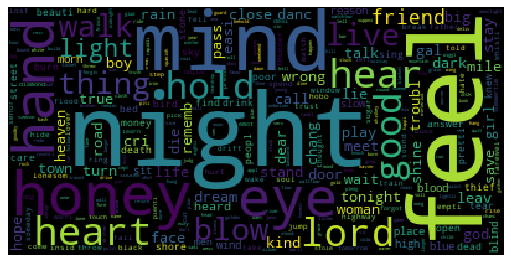

LDA with 30 topics:
Topic n. 0
(26, '0.014*"forgot" + 0.012*"summertim" + 0.009*"coat" + 0.009*"behold" + 0.008*"tree" + 0.008*"someday" + 0.008*"satan" + 0.007*"gold" + 0.007*"strife" + 0.007*"cut" + 0.007*"lost" + 0.007*"sake" + 0.007*"game" + 0.007*"peac" + 0.006*"learn" + 0.006*"whistl" + 0.006*"want" + 0.006*"listen" + 0.006*"honey" + 0.006*"pawn"')

Topic n. 1
(4, '0.012*"feel" + 0.011*"emot" + 0.010*"bell" + 0.010*"ring" + 0.009*"heart" + 0.008*"pass" + 0.008*"blinder" + 0.007*"knock" + 0.007*"santa" + 0.007*"heaven" + 0.007*"auction" + 0.007*"plenti" + 0.007*"summer" + 0.007*"touch" + 0.006*"block" + 0.006*"dear" + 0.006*"lash" + 0.006*"crawl" + 0.006*"desper" + 0.006*"properti"')

Topic n. 2
(18, '0.011*"blue" + 0.009*"dime" + 0.009*"die" + 0.009*"lord" + 0.009*"buy" + 0.008*"sing" + 0.008*"blind" + 0.007*"cold" + 0.007*"good" + 0.006*"rain" + 0.006*"knee" + 0.006*"earli" + 0.006*"pure" + 0.006*"stole" + 0.006*"drown" + 0.006*"grief" + 0.006*"tear" + 0.006*"rage" + 0.006*"quit

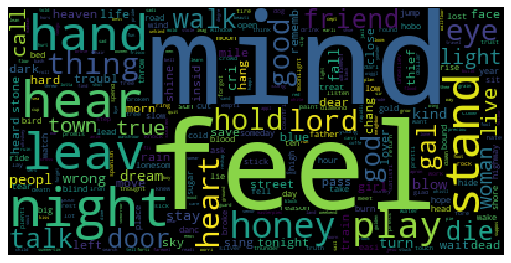

In [0]:
n_topics = n_topics_range[0]

lda = LDA(path, doStem=True, createCorpus = create_corpus)

lda.add_stop_words(path_files+'/stopwords8')

st = None
if create_corpus:
    st = lda.create_and_save_corpus(num_docs=399)
else:
    st = lda.get_corpus(path_files)
dic = corpora.Dictionary(st)
corpus = [dic.doc2bow(text) for text in st]
tfidf = TfidfModel(corpus, wlocal = log_norm)
corpus = tfidf[corpus]

print ("TOPIC MODEL WITH PORTER STEMMING\n")

while (n_topics <= n_topics_range[1]):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=n_topics, id2word=dic, passes=iterations)
    topics = ldamodel.print_topics(num_words=20)
    print ("LDA with "+str(n_topics)+" topics:")
    cont=0
    for topic in topics:
        print("Topic n.", cont)
        print(topic)
        print()
        cont+=1
    print ()
    n_topics+=passo
    to_wc = lda.write_ldamodel_for_wc(ldamodel)
    show_word_cloud(to_wc)